# 2-Sample Tests Power over Increasing Dimension

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [9]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_2samp_dimension
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.sims import *

sys.path.append(os.path.realpath('..'))

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [10]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat

In [11]:
MAX_DIMENSION = 10
STEP_SIZE = 1
DIMENSIONS = range(1, MAX_DIMENSION + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [12]:
SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
    MGC,
    Dcorr,
    Hsic,
    Manova,
    HHG,
    CCA,
    RV,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [ ]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power_2samp_dimension(test, trans_2samp, sim, p=i) for _ in range(POWER_REPS)])
                          for i in DIMENSIONS])
    np.savetxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

In [13]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [16]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Three-Sample Testing Increasing Dimension", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                manova_power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_Manova.csv'.format(sim), delimiter=',')
                
                if test_name == "MGC":
                    col.plot(DIMENSIONS, power - manova_power, color="#e41a1c", label=test_name, lw=4)
                elif test_name == "Manova":
                    col.plot(DIMENSIONS, power - manova_power, label=test_name, lw=4, linestyle='dashed')
                else:
                    col.plot(DIMENSIONS, power - manova_power, label=test_name, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.08, 'Dimension', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power Relative to Manova', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../benchmarks/figs/2samp_power_dimension.pdf', transparent=True, bbox_inches='tight')

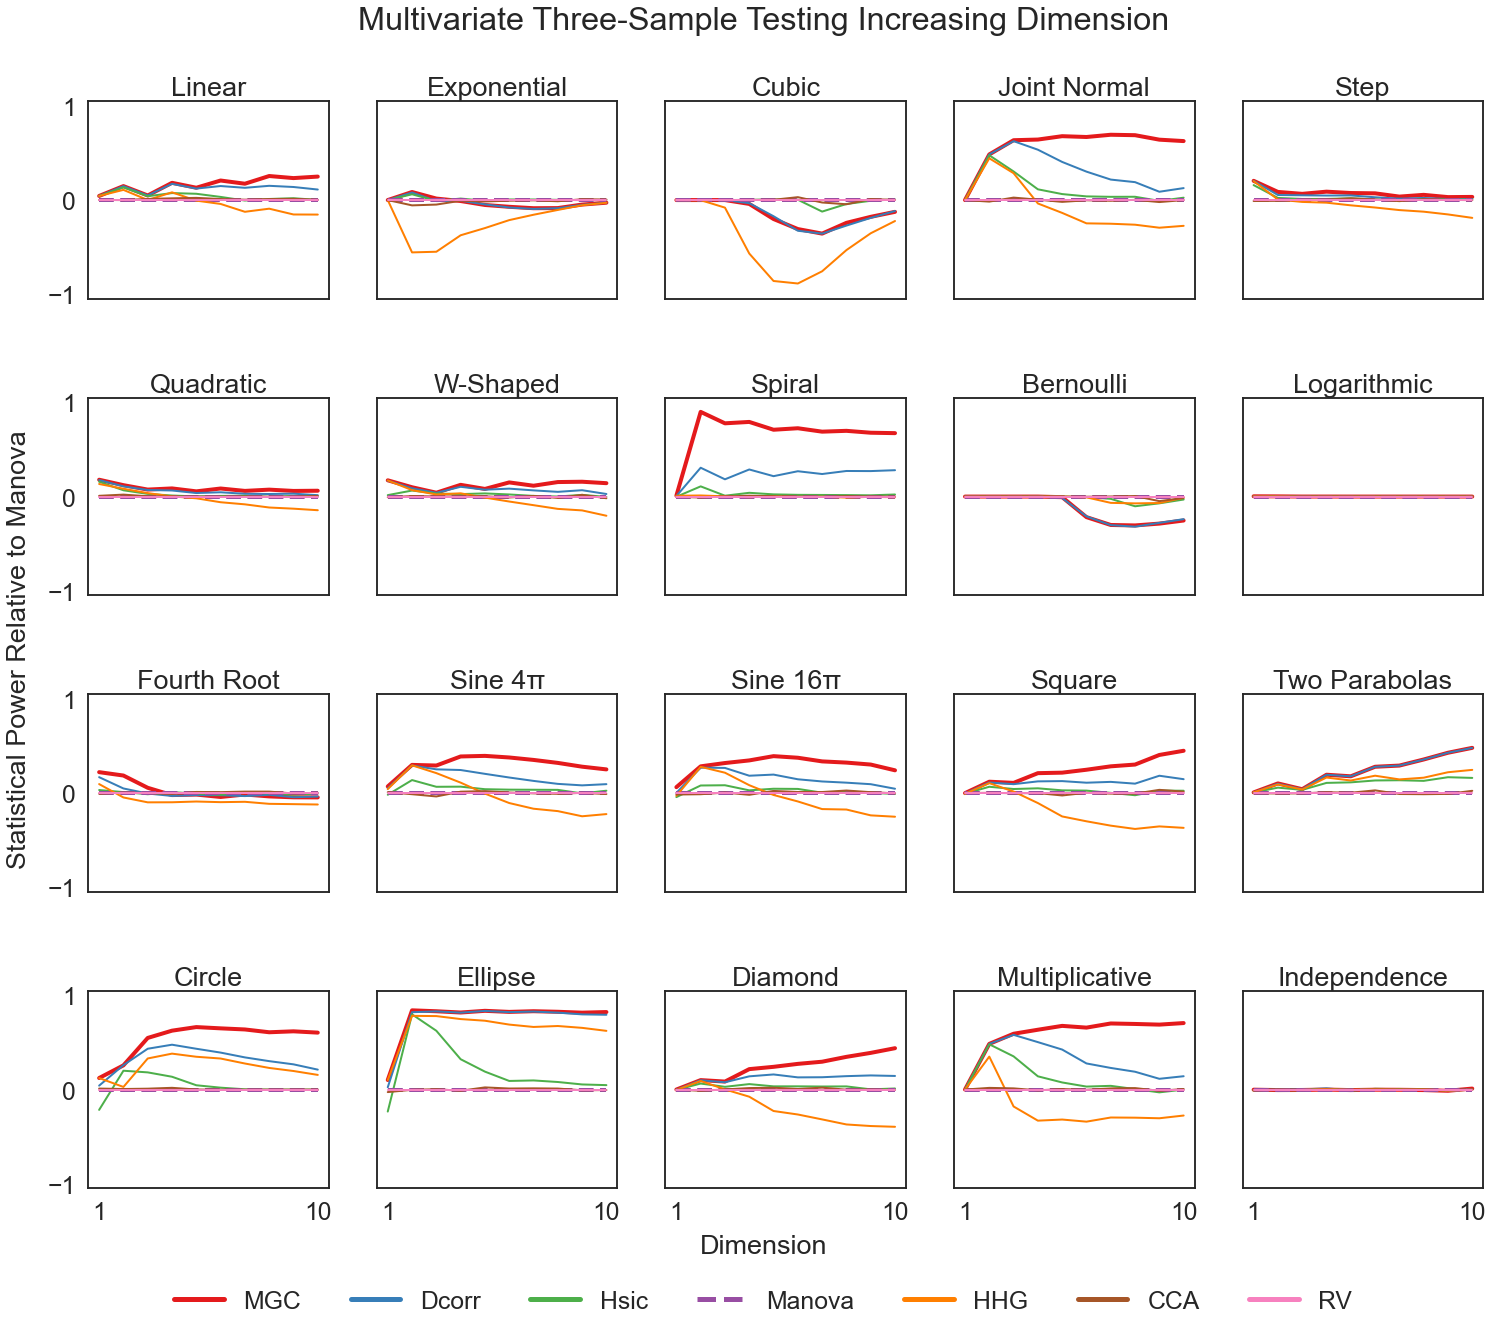

In [17]:
plot_power()